<a href="https://colab.research.google.com/github/viyer-research/GITDemo/blob/master/image_superResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
cd drive/

/content/drive


In [30]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!tar -xf "/content/drive/MyDrive/lfw.tgz" 

^C


In [29]:
!ls /content/drive/MyDrive/

'2015 Calendar.gsheet'
 2018_gans_anomaly.pdf
 20200506_124418.jpg
 20200506_124426.jpg
 20200506_124509.jpg
 20200506_124516.jpg
 20200813_181513.mp4
'20201107_084502 (1).jpg'
'20201107_084502 (2).jpg'
 20201107_084502.jpg
'Algorithm Analysis (Student).gdoc'
 Ancheer-EBike-3-2-21-VI.mp4
 ATR_OAK_D_2021_v2-pages.pdf
 Classroom
'Colab Notebooks'
'Copy of Histogram and Normal Distribution Chart Example.gsheet'
'Copy of Research & Collaboration Tools for Students, Staff & Faculty: Creating a Modern Memex.gdoc'
 cv_1_analytics_GSU-2020.pdf
 Data
 Document.pdf
 ganssurvey.pdf
'Google Earth'
 lfw.tgz
 notes4.png
 OCI-Card-scan.png
'Offer letter Visiting CS Iyer 2019_7_24.pdf'
 operating-system-concepts-10th.zip
'operating-system-concepts-10th.zip (Unzipped Files)'
 pexpipe.zip
 Postdoc_Wisenet_INDURB_2019.pdf
 Report-2013.docx
 Research-2021-ver-3.pdf
 Research-2021-ver-3.zip
 Research-2021-ver-4.zip
 Resume-VI-2019_CYB.zip
'Software Engineering Teams.gform'
 Spring-2020
 SteepestDescentNorm

In [27]:
ls lfw/

ls: cannot access 'lfw/': No such file or directory


In [39]:
cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


[Errno 2] No such file or directory: 'lfw'
/content/drive/MyDrive


In [40]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

In [42]:
face_images = glob.glob('lfw/**/*.jpg') #gives path

print(face_images[:2], len(face_images))

['lfw/George_HW_Bush/George_HW_Bush_0001.jpg', 'lfw/George_HW_Bush/George_HW_Bush_0002.jpg'] 5521


In [43]:
with open('face_images_path.pickle','wb') as f:
  pickle.dump(face_images,f)

In [44]:
from tqdm import tqdm         #A progess library

In [45]:
from multiprocessing import Pool
progress = tqdm(total= len(face_images), position=0)
def read(path):
  img = image.load_img(path, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

p = Pool(10)
img_array = p.map(read, face_images)

0it [06:34, ?it/s]
 10%|█         | 556/5521 [00:18<01:19, 62.36it/s]

In [46]:
with open('img_array.pickle','wb') as f:
  pickle.dump(img_array, f)

In [47]:
len(img_array)

5521

In [48]:
with open('img_array.pickle','rb') as f:
  img_array = pickle.load(f)

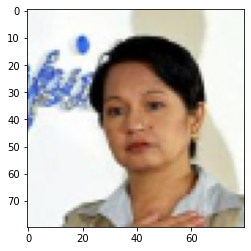

In [49]:
plt.imshow(img_array[100])

In [50]:
all_images = np.array(img_array)

In [51]:
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [52]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image


In [53]:
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

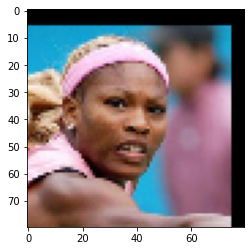

In [54]:

plt.imshow(train_x[100])

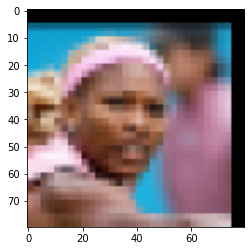

In [55]:
plt.imshow(train_x_px[100])

In [56]:
#lets build the model No TPU
#with strategy.scope():
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)

encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [57]:
autoencoder.summary()
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('superResolution_checkpoint3.h5',save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [58]:
# #Special dataset pipeline for running model on TPU
# def validation_input_fn(batch_size=1024):
#     # Convert the inputs to a Dataset.
#     dataset = tf.data.Dataset.from_tensor_slices((val_x_px, val_x))
# # Shuffle, repeat, and batch the examples.
#     dataset = dataset.cache()
#     dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
#     dataset = dataset.repeat()
#     dataset = dataset.batch(batch_size, drop_remainder=True)
# # Return the dataset.
#     return dataset

In [ ]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=100,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/100
138/138 [==============================] - 61s 200ms/step - loss: 0.0129 - accuracy: 0.7922 - val_loss: 0.0036 - val_accuracy: 0.8874
Epoch 2/100


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


138/138 [==============================] - 26s 192ms/step - loss: 0.0033 - accuracy: 0.8900 - val_loss: 0.0029 - val_accuracy: 0.8970
Epoch 3/100
138/138 [==============================] - 27s 193ms/step - loss: 0.0029 - accuracy: 0.8982 - val_loss: 0.0027 - val_accuracy: 0.8982
Epoch 4/100
138/138 [==============================] - 27s 193ms/step - loss: 0.0027 - accuracy: 0.9033 - val_loss: 0.0026 - val_accuracy: 0.9071
Epoch 5/100
138/138 [==============================] - 27s 193ms/step - loss: 0.0026 - accuracy: 0.9053 - val_loss: 0.0026 - val_accuracy: 0.8964
Epoch 6/100
138/138 [==============================] - 27s 192ms/step - loss: 0.0025 - accuracy: 0.9081 - val_loss: 0.0025 - val_accuracy: 0.9115
Epoch 7/100
138/138 [==============================] - 27s 193ms/step - loss: 0.0025 - accuracy: 0.9100 - val_loss: 0.0024 - val_accuracy: 0.9160
Epoch 8/100
138/138 [==============================] - 27s 193ms/step - loss: 0.0024 - accuracy: 0.9105 - val_loss: 0.0024 - val_accurac

In [ ]:
autoencoder = tf.keras.models.load_model('superResolution_checkpoint3.h5')

In [ ]:
predictions = autoencoder.predict(val_x_px)

In [ ]:
n = 4
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


plt.show()

In [ ]:
results = autoencoder.evaluate(val_x_px, val_x)
print('loss, accuracy', results)

In [ ]:
img = image.load_img('download.jpg', target_size=(80,80,3))
img = image.img_to_array(img)
img = img/255.

In [ ]:
img = pixalate_image(img)
plt.imshow(img)

In [ ]:

input_array = np.array([img])

In [ ]:
predict = autoencoder.predict(input_array)

In [ ]:
plt.imshow(predict[0])